# Cold start forecasting engine demo using AutoGluon AutoML for time series forecasting

This notebook complements the **"Build a cold start time series forecasting engine using AutoGluon AutoML for time series forecasting"** blog post. 

**Noted that we are training the AutoGluon model on [Amazon SageMaker Studio Lab](https://studiolab.sagemaker.aws/), a free computing platform offered by AWS. 

Here we will consider a real use case and show how to use AutoGluon for time series forecasting for predicting energy consumption of newly joined customers given what we have known from exisiting customers.

Specifically, we will demonstrate how to:
- Prepare the dataset 
- Define training parameters using AutoGluon
- Train a cold start forecasting engine using AutoGluon for time series forecasting
- Visualize cold start forecasting predictions

Since AutoGluon Forecasting is still in beta, we will need to follow the steps below to install properly:
- Open a terminal, and execute the code below:
    - `git clone https://github.com/yx1215/autogluon.git`
    - `cd autogluon`
    - `git checkout --track origin/add_forecasting_predictor`


In [ ]:
# change dir to autogluon for installation
import os
os.chdir('autogluon/')
# install packages
!pip install -U pip
!pip install -U setuptools wheel
# execute the bash script for installation
!bash full_install.sh
# make sure env have mxnet install
!pip install mxnet

## Import libraries and setup Boto3 Session

Before starting, we can override the default values for the following if you are executing this notebook on other Amazon platforms other than [Amazon SageMaker Studio Lab](https://studiolab.sagemaker.aws/).

- The [S3](https://aws.amazon.com/s3/) bucket and prefix that you want to use for training and model data. This should be within the same region as the [Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html), training, and hosting.
- The [IAM](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [1]:
!python --version

Python 3.6.15


In [2]:
!pip install pandas sklearn matplotlib boto3 sagemaker

In [3]:
import sys
import random
import datetime
import os
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

# AWS libraries and initialization
import boto3
from sagemaker import get_execution_role
import sagemaker

from autogluon.forecasting import ForecastingPredictor
from autogluon.forecasting import TabularDataset
import autogluon.core as ag
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("util/") )
import util

/home/studio-lab-user/.conda/envs/autogluon/lib/python3.6/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
# If you are executing this notebook on SageMaker instead of SageMaker Studio Lab
# --------------------------
# sess = sagemaker.Session()
# bucketName = 'autogluon-coldstart-demo'

# role = sagemaker.get_execution_role()
# sess = sagemaker.Session(default_bucket=bucketName)

# print(f"SageMaker Role Arn: {role}")
# print(f"SageMaker - Amazon S3 Bucket: {sess.default_bucket()}")
# print(f"SageMaker Session Region: {sess.boto_region_name}")

## Preparing the target time series dataset

Here we use a synthetic dataset based on electricity dataset, which consists of the hourly time series for 370 item_id from 0 to 369.

In this hypothetical senario, our goal is to generate forecasts for 4 new item_id, 370 to 373.

In [5]:
zipLocalFilePath = "data/test.csv.gz"
localFilePath = "data/test.csv"

util.extract_gz(zipLocalFilePath, localFilePath)

Extracting data/test.csv.gz to data/test.csv
Done.


In [6]:
tdf = pd.read_csv(zipLocalFilePath, dtype = object)
tdf.head()

,timestamp,target_value,item_id
0,2014-01-01 01:00:00,2.53807106598985,client_0
1,2014-01-01 01:00:00,23.648648648648624,client_1
2,2014-01-01 01:00:00,0.0,client_2
3,2014-01-01 01:00:00,144.81707317073176,client_3
4,2014-01-01 01:00:00,75.0,client_4


In [7]:
tdf['target_value'] = tdf['target_value'].astype('float')

Let us plot one time series first.

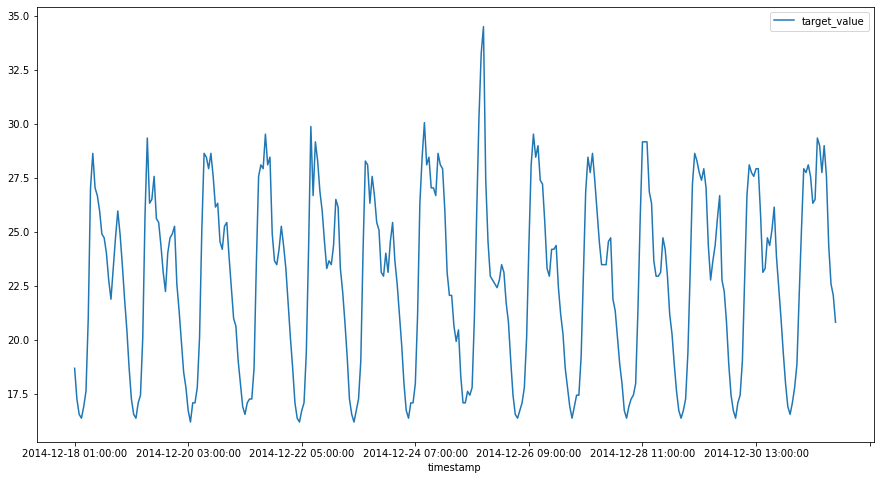

In [8]:
tdf[tdf['item_id'] == 'client_1'][-24*7*2:]\
    .plot(x='timestamp', y='target_value', figsize=(15, 8)); 

## Preparing metadata dataset

Next, we use an item meta information dataset that contains only the non-cold start items (item_id 0 to 369). We call this meta information "type" in this specific case. **In order to generate cold start forecasting, we will need to make sure that the our item meta training data on non-cold start item will already have identical item meta information of cold start items.** This means that if we are to forecast on type A item_id, the model should have already seen type A item_id from the training dataset. 

Although only one categorical features is used in this demo, but in practice one normally has multiple categorical features.

Note that for cold start items where little to none demand history exists, the algorithm can only "transfer" information from the existing items to the new ones through the meta information. Therefore, having informative and high quality meta data is the key for a good cold-start forecast.

In [9]:
# this metadata contains all items, including cold start items' metadata.
localItemMetaDataFilePath = "data/itemMetaData.csv"
imdf = pd.read_csv(localItemMetaDataFilePath, dtype = object)

We will need to encode categorical variables into numeric representation for AutoGluon. We will use [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), where `A=0`, `B=1`, `C=2`, `D=3` after applying onto type column.

In [10]:
# instantiate LabelEncoder() and apply onto categorical col
labelencoder = LabelEncoder()
imdf['type'] = labelencoder.fit_transform(imdf['type'])

# cast categorical column as string / object column
imdf['type'] = imdf['type'].astype(str)

In [11]:
# create item meta data without cold start item as model input
imdf_without_coldstart_item = imdf[imdf.item_id.isin(tdf.item_id.tolist())]
imdf_without_coldstart_item.to_csv('data/itemMetaDatawithoutColdstart.csv', index=False)

# create item meta data with only cold start items, this will be used for inference
imdf_with_coldstart_item = imdf[~imdf.item_id.isin(tdf.item_id.tolist())]
imdf_with_coldstart_item.to_csv('data/itemMetaDataOnlyColdstart.csv', index=False)

print(imdf_without_coldstart_item.tail())
print('\n')
print(imdf_with_coldstart_item.tail())

        item_id type
365  client_365    3
366  client_366    3
367  client_367    3
368  client_368    3
369  client_369    3


        item_id type
370  client_370    0
371  client_371    1
372  client_372    2
373  client_373    3


And the following figure shows the histogram of the category "type."

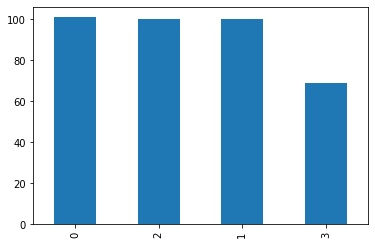

In [12]:
imdf_without_coldstart_item['type'].value_counts().plot(kind='bar');

## Upload data onto s3 [If you are executing on Amazon SageMaker intead of Amazon SageMaker Studio Lab]

In [13]:
# s3 = boto3.client('s3')

# targetTimeseriesDatakey = "targetTimeSeries.csv"
# s3.upload_file(Filename=localFilePath, Bucket = bucketName, Key = f"{targetTimeseriesDatakey}")

# trainingitemMetaDatakey = "itemMetaDatawithoutColdstart.csv"
# s3.upload_file(Filename='data/itemMetaDatawithoutColdstart.csv', Bucket = bucketName, Key = f"{trainingitemMetaDatakey}")

# inferenceitemMetaDatakey = "itemMetaDataOnlyColdstart.csv"
# s3.upload_file(Filename='data/itemMetaDataOnlyColdstart.csv', Bucket = bucketName, Key = f"{inferenceitemMetaDatakey}")

## Set up AutoGluon training

Requirements:

- Each (index, time) combination must only be associated with a single target value in your dataset, you cannot include multiple observations of the same time-series at the same time point. The time values in time_column must be in a valid [pandas time-series format](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) and must be uniformly spaced (eg. every hour, every day, etc.) such that the __[pandas.infer_freq](https://pandas.pydata.org/docs/reference/api/pandas.infer_freq.html)__ function can be successfully applied to these time values. Missing target values should be in a format compatible with [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html). Ideally each index will be observed over the same time points, but if some observations are missing for a particular (index, time) combination, then you can add these to your dataset with target value NA (AutoGluon will otherwise automatically do this padding for you). The ordering of the rows in your dataset does not matter (AutoGluon’s forecasting models rely on the time_column value, not the row ordering).

-  Most of the models used by AutoGluon-Forecasting support GPU training, but it is not required that you train on a GPU. Make sure you have installed CUDA and the GPU version of MXNet, refer to the [installation instructions](http://autogluon-staging.s3-website-us-west-2.amazonaws.com/PR-1198/55/install.html) for more details. AutoGluon will try to automatically detect whether your machine has a properly setup GPU, but you can also manually specify that GPU should be used by setting the `predictor.fit()` argument: `ag_args_fit={'num_gpus': 1}`. Multi-GPU training is not yet supported.

- Generally setting the predictor.fit() argument presets="best_quality" will result in high accuracy. Alternative options include manually specifying hyperparameter search spaces for certain models and manually increasing the number of hyperparameter optimization trials, as demonstrated in [Forecasting Time-Series - In Depth Tutorial](http://autogluon-staging.s3-website-us-west-2.amazonaws.com/PR-1198/55/tutorials/forecasting/forecasting-indepth.html#sec-forecastingindepth).

- This global AG model does not include metadata information, and it will train on 3 different time series models within Autogluon (SFF, MQCNN, and DeepAR)
- Model training is done with `presets=[‘medium_quality_faster_train’]` - Medium predictive accuracy with very fast inference and very fast training time. ~20x faster training than good_quality_faster_inference_only_refit. [doc here](http://autogluon-staging.s3-website-us-west-2.amazonaws.com/PR-1198/55/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit)
    - This is the default preset in AutoGluon, good for prototype.
    - will use `good_quality_faster_inference_only_refit` as it results in significantly better predictive accuracy and faster inference time later.
    - The below screenshot guides how you can perform HPO in AG:
        - ![image info](img/AutoGluon-HPO.png)

In [14]:
save_path = 'electricity-coldstart-demo'
eval_metric = 'MAPE'
forecast_horizon = 24

In [15]:
deepar_params = {
    "scaling":True
}

ag_predictor = ForecastingPredictor(path=save_path, 
                                    eval_metric=eval_metric).fit(tdf,
                                                                 static_features = imdf_without_coldstart_item,
                                                                 prediction_length=forecast_horizon,
                                                                 index_column="item_id",
                                                                 target_column="target_value",
                                                                 time_column="timestamp",
                                                                 quantiles=[0.1, 0.5, 0.9],
                                                                 hyperparameters={"DeepAR": deepar_params})

Training with dataset in tabular format...
Finish rebuilding the data, showing the top five rows.
      item_id  2014-01-01 01:00:00  2014-01-01 02:00:00  2014-01-01 03:00:00  \
0    client_0             2.538071             2.855330             2.855330   
1    client_1            23.648649            23.826458            23.648649   
2   client_10            56.073025            48.435171            43.219076   
3  client_100           141.986063           113.240418           119.337979   
4  client_101           288.639366           255.944518          1274.768824   

   2014-01-01 04:00:00  2014-01-01 05:00:00  2014-01-01 06:00:00  \
0             2.855330             2.538071             2.855330   
1            21.870555            22.048364            21.514936   
2            39.120715            37.816692            34.836066   
3           112.369338           111.498258           106.707317   
4          1786.327609           906.208719           239.101717   

   2014-01-0

## Reload model that is save at `save_path`

If you want to reload any previous models, just provide the path to the output folder as such,

In [18]:
# ag_predictor = ForecastingPredictor.load(save_path)

## Evaluate Model Performances

In [19]:
ag_predictor.fit_summary()

Generating leaderboard for all models trained...


*** Summary of fit() ***
Estimated performance of each model:
    model  val_score  fit_order
0  DeepAR  -0.414781          1
Number of models trained: 1
Types of models trained:
{'DeepARModel'}
Hyperparameter-tuning used: False 
User-specified hyperparameters:
{'DeepAR': {'scaling': True}}
Feature Metadata (Processed):
(raw dtype, special dtypes):
*** End of fit() summary ***


{'model_types': {'DeepAR': 'DeepARModel'},
 'model_performance': {'DeepAR': -0.4147807909938359},
 'model_best': None,
 'model_paths': {'DeepAR': 'electricity-coldstart-demo/models/DeepAR/'},
 'model_fit_times': {'DeepAR': 399.0114188194275},
 'hyperparameter_tune': False,
 'hyperparameters_userspecified': {'DeepAR': {'scaling': True}},
 'model_hyperparams': {'DeepAR': {'freq': 'H',
   'prediction_length': 24,
   'scaling': True,
   'use_feat_static_cat': True,
   'use_feat_static_real': False,
   'cardinality': [4],
   'quantiles': [0.1, 0.5, 0.9],
   'callbacks': [<autogluon.forecasting.models.gluonts_model.abstract_gluonts.callback.EpochCounter at 0x7f1d0f6b3080>,
    <autogluon.forecasting.models.gluonts_model.abstract_gluonts.callback.TimeLimitCallback at 0x7f1d0f6b30f0>]}},
 'leaderboard':     model  val_score  fit_order
 0  DeepAR  -0.414781          1}

Best model is found to be DeepAR at this baseline fitting, with val_score of -4.182935.

In [20]:
# If you have more than one model trained, you can selectively call the best model based on performance
ag_predictor._trainer.get_model_best()

'DeepAR'

In [21]:
models_trained = ag_predictor._trainer.get_model_names_all()
specific_model = ag_predictor._trainer.load_model(models_trained[0])
specific_model.get_info()

{'name': 'DeepAR',
 'model_type': 'DeepARModel',
 'eval_metric': 'MAPE',
 'fit_time': 399.0114188194275,
 'predict_time': 8.273642539978027,
 'val_score': -0.4147807909938359,
 'hyperparameters': {'freq': 'H',
  'prediction_length': 24,
  'scaling': True,
  'use_feat_static_cat': True,
  'use_feat_static_real': False,
  'cardinality': [4],
  'quantiles': [0.1, 0.5, 0.9],
  'callbacks': [<autogluon.forecasting.models.gluonts_model.abstract_gluonts.callback.EpochCounter at 0x7f1d0f5dcb70>,
   <autogluon.forecasting.models.gluonts_model.abstract_gluonts.callback.TimeLimitCallback at 0x7f1d0f5dcdd8>]}}

## Model forecasting on cold start item

Now we are ready to generate the forecasts for the cold start problem. Notice that it is recommended such that at least 5 rows needs to be present for each item. Therefore, for the item that has less than 5 observations, we fill in with NaNs. In the following example, both item_id 370 and 372 have zero observation, i.e., pure cold-start problem, while the other two have 5 target values.

In [22]:
localColdStartDataFilePath = "data/coldStartTargetData.csv"
# validation logic for at least 5 items
cstdf = pd.read_csv(localColdStartDataFilePath, dtype = object)
cstdf.head(20)

,timestamp,target_value,item_id
0,2014-12-31 20:00:00,NaN,client_370
1,2014-12-31 21:00:00,NaN,client_370
2,2014-12-31 22:00:00,NaN,client_370
3,2014-12-31 23:00:00,NaN,client_370
4,2015-01-01 00:00:00,NaN,client_370
5,2014-12-31 20:00:00,0.14,client_371
6,2014-12-31 21:00:00,0.14,client_371
7,2014-12-31 22:00:00,0.15,client_371
8,2014-12-31 23:00:00,0.18,client_371
9,2015-01-01 00:00:00,0.18,client_371


In [23]:
# # Upload file onto s3, execute this code if running on Amazon SageMaker, or have AWS CLI set up on your Amazon SageMaker Studio Lab
# # ---------------------------
# coldStartTargetTimeseriesDatakey = "coldStartTargetData.csv"
# s3.upload_file(Filename=localColdStartDataFilePath, 
#                Bucket = bucketName, 
#                Key = f"{coldStartTargetTimeseriesDatakey}")

Now let's generate some forecast for cold start items!

In [24]:
cold_start_prediction = ag_predictor.predict(cstdf, static_features=imdf_with_coldstart_item)
cold_start_prediction

Does not specify model, will by default use the model with the best validation score for prediction
Predicting with model DeepAR


{'client_370':                           0.1       0.5        0.9
 2015-01-01 01:00:00 -1.676151  0.769164   2.937428
 2015-01-01 02:00:00 -1.063728  1.209301   3.843664
 2015-01-01 03:00:00 -0.605510  1.314570   3.524535
 2015-01-01 04:00:00 -0.090058  1.562565   3.837157
 2015-01-01 05:00:00 -0.203298  1.939340   4.217663
 2015-01-01 06:00:00 -0.518757  1.975091   5.317965
 2015-01-01 07:00:00  0.460114  2.114171   5.532070
 2015-01-01 08:00:00 -0.101450  2.144658   5.475315
 2015-01-01 09:00:00 -0.145659  2.448890   5.787745
 2015-01-01 10:00:00  0.154982  2.682061   5.812719
 2015-01-01 11:00:00  0.265423  2.834498   6.758393
 2015-01-01 12:00:00  0.358093  2.873165   7.698951
 2015-01-01 13:00:00  0.117551  3.287156   8.794640
 2015-01-01 14:00:00  0.632933  3.720759   8.132318
 2015-01-01 15:00:00  0.472304  3.798501   8.811880
 2015-01-01 16:00:00  0.637495  3.783036   7.870986
 2015-01-01 17:00:00 -0.386592  4.173224   8.364869
 2015-01-01 18:00:00  0.571502  3.844749  10.32366

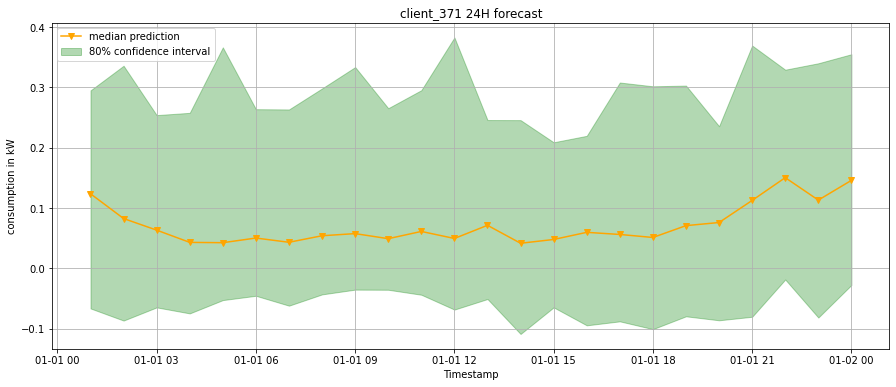

{'client_370':                           0.1       0.5        0.9
 2015-01-01 01:00:00 -1.676151  0.769164   2.937428
 2015-01-01 02:00:00 -1.063728  1.209301   3.843664
 2015-01-01 03:00:00 -0.605510  1.314570   3.524535
 2015-01-01 04:00:00 -0.090058  1.562565   3.837157
 2015-01-01 05:00:00 -0.203298  1.939340   4.217663
 2015-01-01 06:00:00 -0.518757  1.975091   5.317965
 2015-01-01 07:00:00  0.460114  2.114171   5.532070
 2015-01-01 08:00:00 -0.101450  2.144658   5.475315
 2015-01-01 09:00:00 -0.145659  2.448890   5.787745
 2015-01-01 10:00:00  0.154982  2.682061   5.812719
 2015-01-01 11:00:00  0.265423  2.834498   6.758393
 2015-01-01 12:00:00  0.358093  2.873165   7.698951
 2015-01-01 13:00:00  0.117551  3.287156   8.794640
 2015-01-01 14:00:00  0.632933  3.720759   8.132318
 2015-01-01 15:00:00  0.472304  3.798501   8.811880
 2015-01-01 16:00:00  0.637495  3.783036   7.870986
 2015-01-01 17:00:00 -0.386592  4.173224   8.364869
 2015-01-01 18:00:00  0.571502  3.844749  10.32366

In [25]:
def plot_prob_forecasts(df, client_id):
    
    subset_df = df[client_id]
    forecast_entry = subset_df[['0.1', '0.5', '0.9']]  
    
    legend = ["median prediction", "80% confidence interval"]
    
    fig = plt.figure(figsize=(15, 6))
    p10 = forecast_entry['0.1']
    p90 = forecast_entry['0.9']
    plt.plot(forecast_entry['0.5'], color='orange', marker='v')
    plt.fill_between(p10.index, p10, p90, color='g', alpha=0.3, label='80% confidence interval')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(client_id+' 24H forecast')
    plt.xlabel('Timestamp')
    plt.ylabel('consumption in kW')
    plt.show()
    
    display(df)

plot_prob_forecasts(df=cold_start_prediction, client_id='client_371')